# Inspect time series based on Dat

In [1]:
#Import required libraries
import os
import numpy as np
import pandas as pd
import data_reader.data_processing as proc
import matplotlib.pyplot as plt
import analyses.transient as sta
import h5py
import seaborn as sns

In [2]:
sourcedatadir = "E:/Saturated_flow/EGUGoldschmidtdataset6"
hdf5directory = "Y:/Home/khurana/4. Publications/Restructuring"

In [3]:
Regimes = ["Slow", "Equal", "Fast"]
gvarnames = ["DO", "DOC", "Nitrate", "Ammonium"]#, "TOC", "Nitrogen"]
imposedtimeseries = ["1","2","5"]
Trial = proc.masterscenarios("Saturated").keys()

In [4]:
#Generate Dat from Da and Pe
data  = pd.read_csv(os.path.join(hdf5directory,"Paper1","Figurecodes", "Da_29012021_95pcloss.csv"), sep=",")
data["logDa"] = np.log10(data.Da63)

In [5]:
#Consider time series in terms of Dat.
#Sort all the values in Dat
finaldata = data[data['Chem'].isin (gvarnames)]
mymarklist = ["^", "o", "s", "d"]
reglist = ["Slow", "Medium", "Fast"]
colorlist = ["indianred", "g", "steelblue"]

finaldata.loc[finaldata["logDa"] > 0.5, "PeDamark"] = 3
finaldata.loc[(finaldata["logDa"] > 0) & (finaldata["logDa"] < 0.5), "PeDamark"] = 2
finaldata.loc[(finaldata["logDa"] > -1) & (finaldata["logDa"] < 0), "PeDamark"] = 1
finaldata.loc[finaldata["logDa"] < -1, "PeDamark"] = 0

labels = {0 : 'log$_{10}$Da < -1',
          1 : '-1 < log$_{10}$Da < 0',
          2 : '0 <log$_{10}$Da < 0.5',
          3 : 'log$_{10}$Da > 0.5'}

subfinal = finaldata[["Trial", "Regime", "Chem", "Time_series","PeDamark"]]
subfinal['key'] = subfinal.Trial + subfinal.Regime + subfinal.Chem + subfinal.Time_series.astype(str)
colorcriteria = subfinal[["PeDamark", "key"]].to_dict('records')
colorcriteria = dict(zip(subfinal['key'], subfinal['PeDamark']))

PeDapalette = {0: "blue", 1: "orange", 2: "g", 3: "indianred"}

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

## Generate a time series file (HDF5 format) to store all the data

### Data is essentially concentration of reactive species leaving the domain normalized by that in the uniform flow scenario

In [ ]:
h5file = h5py.File(os.path.join(hdf5directory, "Paper2", "Figurecodes","Temporal_analysis_full_data.h5"), mode = 'w')
for Reg in Regimes:
    basedata = np.load(os.path.join(sourcedatadir, Reg + "AR_0/NS-AH/NS-AH_df.npy"))
    basevelocity = np.mean(basedata[2, -1, :, :])
    for t in imposedtimeseries:
        directory = os.path.join(sourcedatadir,Reg + "AR_" + t)
        print (Reg, t)
        for j in Trial:
                if ((j == '52' and t == "5") or (j == '43' and t == "1")):
                    pass
                else:
                    basefile = os.path.join(Reg + "AR_0","NS-A"+j,"NS-A"+j+"_df.npy")
                    basedata = np.load(os.path.join(sourcedatadir, basefile))
                    baseconcs, flow, heads = sta.conc_time (basedata,0,-1,0,-1, 51, gvarnames, "Saturated")
                    data = np.load(os.path.join(directory, "NS-A"+j,"NS-A"+j+"_df.npy"))
                    concs, flow, heads = sta.conc_time (data,0,-1,0,-1, 51, gvarnames, "Saturated")
                    subconcs = concs[1:, -1, :]/baseconcs[-1, -1,:]
                    for g in gvarnames:
                        dataset_name = t + "/" + Reg + "/" + j + "/" + g
                        print(dataset_name)
                        h5file.create_dataset(dataset_name, data=subconcs[:, gvarnames.index(g)])
h5file.close()

### Identify the time series and categorize in Dat categories from Paper 1 effort

In [ ]:
#Load already generated time series
hr = h5py.File(os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_data.h5"), mode = 'r')
#Write new time series in a new HDF5 file
hw = h5py.File(os.path.join(hdf5directory,"Paper2","Figurecodes","Temporal_analysis_full_Dat.h5"), mode = 'w')
print(hr.keys())

for t in imposedtimeseries:
    n0=[]
    n1=[]
    n2=[]
    n3=[]
    for Reg in Regimes:
        if Reg == "Equal":
            r = "Medium"
        else:
            r = Reg    
        for g in gvarnames:
            for j in Trial:
                if ((j == '52' and t == "5") or (j == '43' and t == "1")):
                    pass
                else:      
                    #print(t, r, g, j)
                    n = hr.get(t + "/" + Reg + "/" + j + "/" + g).value
                    if int(colorcriteria[j+r+g+"0"]) == 0:
                        n0.append(n)
                    elif int(colorcriteria[j+r+g+"0"]) == 1: 
                        n1.append(n)
                    elif int(colorcriteria[j+r+g+"0"]) == 2:
                        n2.append(n)
                    elif int(colorcriteria[j+r+g+"0"]) == 3:
                        n3.append(n)
    for Dat, k in zip([0,1,2,3],[n0, n1, n2, n3]):
        df = pd.DataFrame.from_records(k)
        #Then take average at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/mean/", data=df.mean())
        #Then take average at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/median/", data=df.median())
        #Then take minimum at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/min/", data=df.min())
        #Then take maximum at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/max/", data=df.max())
        #Then take 0.25 quantile at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/q25/", data=df.quantile(0.25))
        #Then take 0.75 quantile at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/q75/", data=df.quantile(0.75))
        #Then take 0.1 quantile at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/q10/", data=df.quantile(0.1))
        #Then take 0.9 quantile at each time point
        hw.create_dataset(t + "/Dat" + str(Dat) + "/q90/", data=df.quantile(0.9))
hr.close()
hw.close()

## Plot the time series in terms of Dat

In [ ]:
#Characteristic to plot:
datafeature = "median"
imposedtimeseries = ["1","2","5"]
#Load dataset for time series in terms of Dat
hr = h5py.File(os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_Dat.h5"), mode = 'r')
#Load dataset for base velocity ratio values which will be plotted in the graph
basedata = np.load(os.path.join(sourcedatadir, "SlowAR_0/NS-AH/NS-AH_df.npy"))
basevelocity = np.mean(basedata[2, -1, :, :])
fig, ax = plt.subplots(3, 1, figsize = (10,8), sharey = True, sharex = True)
for t in imposedtimeseries:
    a = ax.flat[imposedtimeseries.index(t)]
    a.set_title("Time series: T"+ t, fontsize = 16)
    for Dat in [0,1,2,3]:
        n = hr.get(t + "/Dat" + str(Dat) + "/"+datafeature+"/").value
        print(np.shape(n))
        a.plot(n[1:], label = labels[Dat], color = PeDapalette[Dat])
        #a.plot(np.convolve(n[1:], np.ones((3,))/3,mode = 'valid'), label = Dat)
    directory = os.path.join(sourcedatadir, "SlowAR_" + t)
    for j in ["37"]:
        a = ax.flat[imposedtimeseries.index(t)]
        data = np.load(os.path.join(directory,"NS-A"+j,"NS-A"+j+"_df.npy"))
        velocity = np.mean(data[2, :, :, :], axis = (-1,-2))/basevelocity
        a.plot(np.abs(velocity[1:]), color= "gray")
a.legend(ncol = 2)
#locs, labels1 = a.xticks()
plt.xticks((0,365,730,1095), (0,5,10,15))
a.set_xlabel ("Time (years)", fontsize = 18)
for a, typsp in zip(ax, imposedtimeseries):
    a.set_title("Time series: "+typsp, fontsize=15)
plt.annotate("Ratio with respect to steady state conditions",
        xy=(0, 1.8),
        xytext=(-50, -10),
        xycoords="axes fraction",
        textcoords="offset points",
        size="large",
        ha="left",
        va="center",
        rotation="vertical",
        fontsize=18)
picname = os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_data.png")
#plt.savefig(picname, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)
hr.close()

In [ ]:
#Characteristic to plot:
features = ["median"]
featurestyle = ["solid"]
imposedtimeseries = ["1","2","5"]
#Load dataset for time series in terms of Dat
hr = h5py.File(os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_Dat.h5"), mode = 'r')
#Load dataset for base velocity ratio values which will be plotted in the graph
basedata = np.load(os.path.join(sourcedatadir, "SlowAR_0/NS-AH/NS-AH_df.npy"))
basevelocity = np.mean(basedata[2, -1, :, :])
fig, ax = plt.subplots(4, 3, figsize = (16,8), sharey = True, sharex = True)
for t in imposedtimeseries:
    directory = os.path.join(sourcedatadir, "SlowAR_" + t)
    for j in ["37"]:
        data = np.load(os.path.join(directory,"NS-A"+j,"NS-A"+j+"_df.npy"))
        velocity = np.mean(data[2, :, :, :], axis = (-1,-2))/basevelocity
        for a in ax[:,imposedtimeseries.index(t)]:
            a.plot(np.abs(velocity[1:]), color= "gray", alpha = 0.7)
    for Dat,pedacol in zip([0,1,2,3],PeDapalette):
        axidx = Dat*len(imposedtimeseries) + imposedtimeseries.index(t)
        a = ax.flat[axidx]
        for datafeature,featureline in zip(features,featurestyle):
            n = hr.get(t + "/Dat" + str(Dat) + "/"+datafeature+"/").value
            nmin = hr.get(t + "/Dat" + str(Dat) + "/q25/").value
            nmax = hr.get(t + "/Dat" + str(Dat) + "/q75/").value
            print(np.shape(n))
            a.plot(n[1:], label = labels[Dat], color = PeDapalette[Dat], linestyle=featureline)
            a.fill_between(np.asarray(list(range(1095))),nmin, nmax, color = PeDapalette[Dat], alpha = 0.4)
        if axidx <3:
            a.set_title("Time series: T"+ t, fontsize = 16)
        if axidx%3==2:
            a.legend(loc="upper left", fontsize = 14)
        if (t=="1") or (Dat==-1):
            a.tick_params(labelsize = 14)
plt.xticks((0,365,730,1095), (0,5,10,15))
plt.annotate("Ratio with respect to steady state conditions",
        xy=(-2.6, 2.25),
        xytext=(0, 0),
        xycoords="axes fraction",
        textcoords="offset points",
        size="large",
        ha="left",
        va="center",
        rotation="vertical",
        fontsize=18)
plt.annotate("Time (years)",
        xy=(-1.0,-0.3),
        xytext=(0, 0),
        xycoords="axes fraction",
        textcoords="offset points",
        size="large",
        ha="left",
        va="center",
        fontsize=18)
picname = os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_data.png")
plt.savefig(picname, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)
hr.close()

### Pairplot to see variation in velocity linked with variation in concentration

<ipython-input-67-ff8d96de14ba>:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  n = hr.get(t + "/" + Reg + "/" + j + "/" + g).value


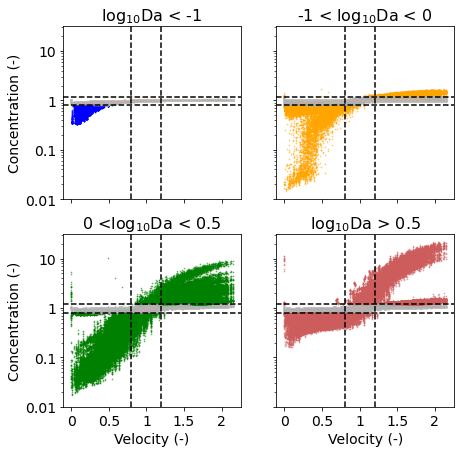

In [67]:
basedata = np.load(os.path.join(sourcedatadir, "SlowAR_0/NS-AH/NS-AH_df.npy"))
basevelocity = np.mean(basedata[2, -1, :, :])
hr = h5py.File(os.path.join(hdf5directory, "Paper2","Figurecodes","Temporal_analysis_full_data.h5"), mode = 'r')
fig,ax = plt.subplots(2,2, figsize = (7,7), sharex = True, sharey = True)
for danum in [0,1,2,3]:
    n_danum = []
    vel_all3 = []
    axe = ax.flat[danum]
    axe.set_title(labels[danum], fontsize = 16)
    axe.axhline(y=1.2, color = "black", linestyle = "dashed")
    axe.axhline(y=0.80, color = "black", linestyle = "dashed")
    axe.axvline(x=1.2, color = "black", linestyle = "dashed")
    axe.axvline(x=0.80, color = "black", linestyle = "dashed")
    for t in imposedtimeseries:
        n_danumt = []
        directory = os.path.join(sourcedatadir, "SlowAR_" + t)
        for j in ["37"]:
            data = np.load(os.path.join(directory,"NS-A"+j,"NS-A"+j+"_df.npy"))
            velocity = np.mean(data[2, :, :, :], axis = (-1,-2))/basevelocity
        vel_all3.append(velocity)
        for Reg in Regimes:
            if Reg == "Equal":
                r = "Medium"
            else:
                r = Reg    
            for g in gvarnames:
                for j in Trial:
                    if ((j == '52' and t == "5") or (j == '43' and t == "1")):
                        pass
                    elif int(colorcriteria[j+r+g+"0"]) == danum:
                        n = hr.get(t + "/" + Reg + "/" + j + "/" + g).value
                        n_danum.append(n)
                        n_danumt.append(n)
                    else:
                        pass
        datapv = np.asarray(n_danumt).transpose()
        for col in list(range(np.shape(datapv)[1])):
            columndata = datapv[:,col]
            colorindex = np.argwhere((columndata<=0.8) | (columndata>=1.2))
            grayindex = np.argwhere((columndata>0.8) & (columndata<1.2))
            axe.scatter(velocity[colorindex],columndata[colorindex], color = PeDapalette[danum], alpha = 0.5, s = 0.5, edgecolor = None)
            axe.scatter(velocity[grayindex],columndata[grayindex], color = "gainsboro", alpha = 0.2,s = 0.5, edgecolor = "white")
    axe.tick_params(labelsize = 14)
    axe.set_yscale("log")
    if danum %2==0:
        axe.set_ylabel("Concentration (-)", fontsize = 14)
    if danum >1:
        axe.set_xlabel("Velocity (-)", fontsize = 14)
    plt.xticks ((0,0.5,1,1.5,2),(0,0.5,1,1.5,2),fontsize = 14)
    plt.yticks ((0.01,0.1,1,10),(0.01,0.1,1,10),fontsize = 14)